## Task 1.

In [1]:
import requests
import pandas as pd

In [2]:
# Write a Python script that retrieves a list of all books 
# with the title ‚Äúlord of the rings‚Äù from the below API 
# (https://openlibrary.org/dev/docs/api/search)

url = "https://openlibrary.org/search.json"
params= {
    'title': 'lord of the rings',
    'limit': 1000
}

api_data = requests.get(url, params=params).json()
print(f"{api_data['numFound']} works with title 'lord of the rings'")

437 works with title 'lord of the rings'


In [4]:
#Parse the response from the API and write the names of the books to a dataset.
#BOOKS format = paperback OR hardcover

api_books = []

# for each result (dictionary within list)
for doc_index, doc_result in enumerate(api_data['docs']):
    # check if 'format' key is present
    try:
        #print(f"{
        api_data['docs'][doc_index]['format']
        #}")
    except KeyError: # If there is no 'format' key - add to books list
        #print(f"KeyError : {api_data['docs'][doc_index]['title']} at index {doc_index} does not have a format")
        api_books.append(api_data['docs'][doc_index])
    except Exception as error:
        print(f"Other Error: {error}") # or like error.args and others to pinpoint the error - look this up
    else : # there is a 'format' key
    # check if one of the formats listed is a BOOK, if so add it to list of BOOKS
        for format_index, format_type in enumerate(api_data['docs'][doc_index]['format']):
            if ('paperback' or 'hardcover' or 'e-book') in api_data['docs'][doc_index]['format'][format_index].lower():
                #print(f"{api_book_check[doc_index]['title']} is a {api_book_check[doc_index]['format'][format_index]}")
                api_books.append(api_data['docs'][doc_index])
                break

print(f"{len(api_books)} of the {api_data['numFound']} are books")

363 of the 437 are books


In [5]:
# Parse the response from the API and write the names of the books to a dataset.
# Add 4 other columns showing data from the response 
lotr_dataset = pd.DataFrame.from_records(api_books)[['title', 'author_name', 'first_publish_year','publisher']]
lotr_dataset.head()

title                          author_name  \
0                The Lord of the Rings                     [J.R.R. Tolkien]   
1  Novels (Hobbit / Lord of the Rings)                     [J.R.R. Tolkien]   
2                 The Lord of the Ring  [Phil Anderson, Philip A. Anderson]   
3                    Lord of the Rings                   [Cedco Publishing]   
4                The lord of the rings                        [Jude Fisher]   

   first_publish_year                                          publisher  
0              1954.0  [Houghton Mifflin Harcourt Publishing Company,...  
1              1979.0  [Highbridge Audio, Mariner Books, HarperCollin...  
2              2006.0  [Regal Books, Muddy Pearl, Kingsway Publications]  
3              2001.0                         [Cedco Publishing Company]  
4              2001.0                  [HarperCollins, Houghton Mifflin]

## Task 2. Query a Specific Dataset

In [37]:
from luqum.parser import parser
from luqum.pretty import prettify
import matplotlib.pyplot as plt

Task 2a. Quick Overview of OpenLibrary Data

In [8]:
%%time
# Create a very general query for books whose author_name is NOT blank
query1 = parser.parse('author_name: [* TO *]')

# Convert the query to a Solr query string
solr_query1 = prettify(query1)

# endpoint URL for Open Library search API
url1 = "https://openlibrary.org/search.json"

# Query parameters
params1 = {
    'q': solr_query1,
    'sort': 'random',
    'fields': 'first_publish_year,title,author_name,language,number_of_pages_median,publisher,subject,ratings_average,ratings_sortable,ratings_count,readinglog_count,want_to_read_count,currently_reading_count,already_read_count,first_sentence',
    'limit': 50000 # Number of results per page
}

try:
    response = requests.get(url1, params=params1)
    response.raise_for_status()  # Check for HTTP errors
    openlib_data = response.json()  # Attempt to parse JSON
    print(f"{openlib_data['numFound']} works")
except requests.exceptions.RequestException as e:
    print(f"Request failed: {e}")
except ValueError as e:
    print(f"JSON decoding failed: {e}")

33492762 works
CPU times: user 318 ms, sys: 293 ms, total: 610 ms
Wall time: 2min 10s


In [35]:
def fetch_books(query, sort_by, limit=20000):
    """
    Fetch books from Open Library based on a Solr query.

    Args:
    query (str): The Solr query string.
    limit (int): The maximum number of results per page.

    Returns:
    dict: The JSON response from the Open Library API.
    """
    url = "https://openlibrary.org/search.json"
    params = {
        'q': query,
        'sort': sort_by,
        'fields': 'first_publish_year,title,author_name,language,number_of_pages_median,publisher,subject,ratings_average,ratings_sortable,ratings_count,readinglog_count,want_to_read_count,currently_reading_count,already_read_count,first_sentence',
        'limit': limit
    }
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        return response.json()
    except requests.exceptions.RequestException as e:
        print(f"Request failed: {e}")
        return None
    except ValueError as e:
        print(f"JSON decoding failed: {e}")
        return None

def main():
    query = prettify(parser.parse('author_name: [* TO *]'))
    sort_by = 'random'
    openlib_data = fetch_books(solr_query, sort_by)
    
    if openlib_data:
        print(f"{openlib_data['numFound']} works found")
        openlib_df = pd.DataFrame.from_records(openlib_data['docs'])
        print(openlib_df.head())
        # Save the DataFrame to a CSV file
        openlib_df.to_csv('open_library_books.csv', index=False)
    else:
        print("No data fetched.")

if __name__ == "__main__":
    main()

167496 works found
                     author_name  first_publish_year language  \
0           [Jonathan Steinberg]              1976.0    [eng]   
1                 [Klaus Janson]              2003.0    [eng]   
2  [Bryn Holmes, John R Gardner]              2006.0    [eng]   
3            [Joan Lowery Nixon]              1979.0    [eng]   
4               [Jon Kabat-Zinn]              2006.0    [eng]   

   number_of_pages_median                                          publisher  \
0                   300.0                       [Cambridge University Press]   
1                   128.0      [Watson-Guptill, Watson-Guptill Publications]   
2                   224.0  [SAGE Publications, Limited, Sage Publications...   
3                   190.0  [Harcourt Childrens Books, Bantam Doubleday De...   
4                     NaN                                      [Sounds True]   

                                   title  \
0                       Why Switzerland?   
1   The DC Comics Gui

In [9]:
# How complete is the database for our selected columns?
openlib_df = pd.DataFrame.from_records(openlib_data['docs'])
openlib_df.isnull().sum().sort_values(ascending=False)/len(openlib_df)

ratings_average            0.99378
ratings_sortable           0.99378
ratings_count              0.99378
first_sentence             0.98862
readinglog_count           0.85066
want_to_read_count         0.85066
currently_reading_count    0.85066
already_read_count         0.85066
subject                    0.49128
number_of_pages_median     0.37372
language                   0.13772
publisher                  0.03852
first_publish_year         0.01866
author_name                0.00000
title                      0.00000
dtype: float64

In [17]:
# What about duplicates?
openlib_df['title'].duplicated().sum()/len(openlib_df)

np.float64(0.00548)

Text(0.5, 1.0, 'Open Library Unread to Read Pipeline')

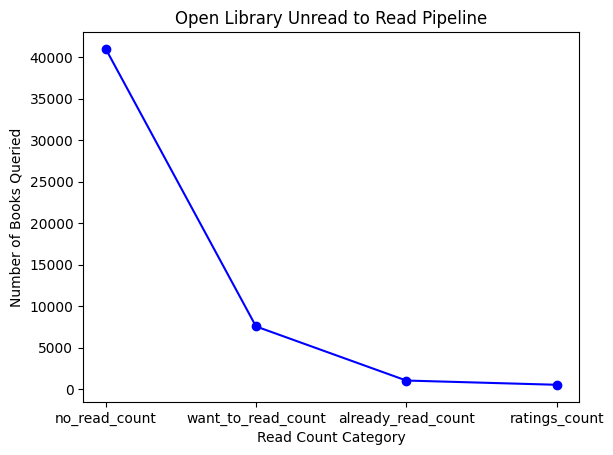

In [12]:
# How many books are users engaging with?

# Create dictionary for subset of data 'Reading Pipeline'
read_dict = {}
read_dict['no_read_count'] = len(openlib_df) - round(openlib_df['readinglog_count'].sum(),2)
read_dict['want_to_read_count'] = round(openlib_df['want_to_read_count'].sum(),2)
read_dict['already_read_count'] = round(openlib_df['already_read_count'].sum(),2)
read_dict['ratings_count'] = round(openlib_df['ratings_count'].sum(),2)
# Create dataframe from dictionary
readcount_df = pd.DataFrame.from_dict(read_dict, orient='index')
# Plot pipeline
plt.plot(readcount_df, marker='o', linestyle='-', color='b', label='Read Count')
plt.xlabel('Read Count Category')
plt.ylabel('Number of Books Queried')
plt.title('Open Library Unread to Read Pipeline')

{'no_read_count': np.float64(41001.0), 'want_to_read_count': np.float64(7543.0), 'already_read_count': np.float64(1022.0)}


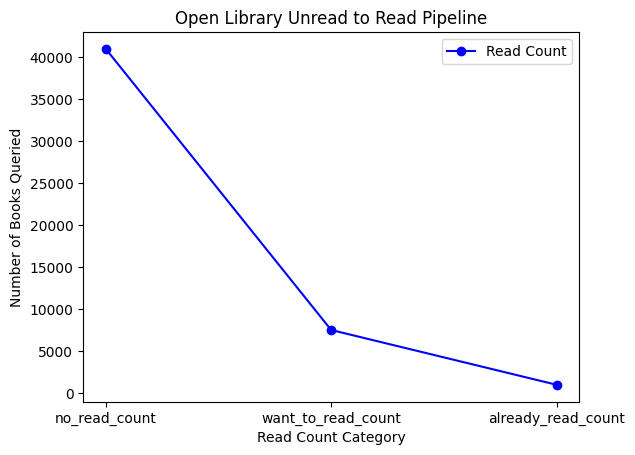

In [40]:
def create_read_count_dict(df):
    """
    Create a dictionary for read counts based on the DataFrame.

    Args:
    df (pd.DataFrame): The input DataFrame containing read counts.

    Returns:
    dict: A dictionary with read counts.
    """
    read_dict = {
        'no_read_count': len(df) - round(df['readinglog_count'].sum(), 2),
        'want_to_read_count': round(df['want_to_read_count'].sum(), 2),
        'already_read_count': round(df['already_read_count'].sum(), 2)
    }
    return read_dict

def plot_read_counts(read_dict):
    """
    Plot the read counts from the dictionary.

    Args:
    read_dict (dict): The dictionary containing read counts.
    """
    readcount_df = pd.DataFrame.from_dict(read_dict, orient='index', columns=['count'])
    
    plt.plot(readcount_df, marker='o', linestyle='-', color='b', label='Read Count')
    plt.xlabel('Read Count Category')
    plt.ylabel('Number of Books Queried')
    plt.title('Open Library Unread to Read Pipeline')
    plt.legend()
    plt.show()

def main():
    try:
        # Create read count dictionary
        read_dict = create_read_count_dict(openlib_df)
        print(read_dict)

        # Plot the read counts
        plot_read_counts(read_dict)
    except FileNotFoundError:
        print("Error: The file 'open_library_books.csv' was not found.")
    except pd.errors.EmptyDataError:
        print("Error: The file is empty.")
    except KeyError as e:
        print(f"Error: Missing expected column in the DataFrame - {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

if __name__ == "__main__":
    main()

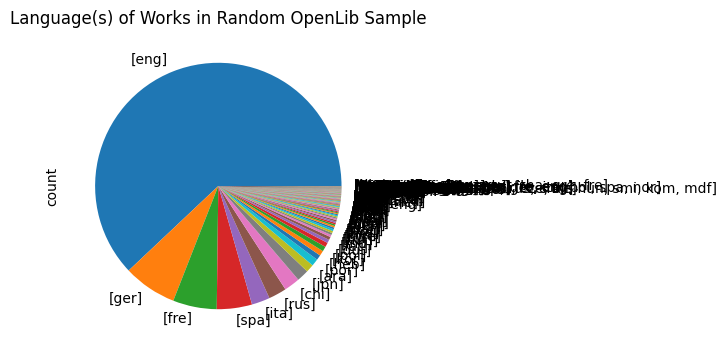

In [13]:
# What languages are most works in?
# Look at language representation in sample
lang_counts = openlib_df['language'].value_counts()
# Plot the outcome
plt.figure(figsize=(4,4))
lang_counts.plot(kind='pie')
plt.title('Language(s) of Works in Random OpenLib Sample')
plt.show()




In [14]:
# How does it look in terms of publisher?
row_limit = params1['limit']
pub_nan = openlib_df['publisher'].isna().sum()

# Function to check if 'Independently published' is in the list, case insensitive
def contains_independently_published(publishers):
    if isinstance(publishers, list):
        return any('independently published' in publisher.lower() for publisher in publishers)
    return False

# Count the rows where the publisher column meets the criteria
pub_ind = openlib_df['publisher'].apply(contains_independently_published).sum()
pub_other = row_limit - pub_nan - pub_ind

print(f" NaN: {pub_nan} ({pub_nan/row_limit}), Independent: {pub_ind} ({pub_ind/row_limit}), Other: {pub_other} ({pub_other/row_limit}).")

 NaN: 1926 (0.03852), Independent: 5101 (0.10202), Other: 42973 (0.85946).


Task 2b. Narrow down dataset

## What makes a great book in OpenLibrary? üìö

**Specifically: *What features contribute to the reading preferences of OpenLibrary's users?*** 

**Scoping and Assumptions:**
*Query Scope*
- I will be limiting my query to works that have **at least one readinglog_count**.
- I will initially limit the **first_publish_year to 2019** to run through my operations on a limited dataset before building it out to multiple years

*Measures of popularity and preference*
- I will be using **readinglog_count** and **rating** as the outcome measures.
  - Its important to note that readinglog_count does not indicate the number of times that a book has been borrowed through OpenLibrary, but is a sum of the user-entered fields *want_to_read_count, currently_reading_count,* and *already_read_count*. This means it is not the perfect measure of popularity of a book - ideally we'd use data from the borrowing log, or page clicks. I reached out to the OpenLibrary program manager 'Mek' (Michael...) however he confirmed this data was not available to the public. So we'll have to rely on this for now.

*Features under consideration*
- The following features are being considered to determine which factors are the best predictors (and therefore make the greatest contribution) to the popularity and rating of books for OpenLibrary's users.
  - 'first_publish_year, title, author_name, language, number_of_pages_median,publisher, format, subject, ratings_average, ratings_sortable, ratings_count, readinglog_count, want_to_read_count, currently_reading_count, already_read_count, first_sentence',

In [26]:
import seaborn as sns

In [19]:
"""
Step 1. Construct and Convert the Query with Luqum (to be readable by apache solr, the query type specified in OpenLibrary's documentation)
"""

# Create a query for books first published in 2019 and with readinglog_count > 0 and with median number of pages between 1 and 4000[*]
query = parser.parse('readinglog_count:[1 TO *] AND ratings_count:[1 TO *] AND language:eng')

# Convert the query to a Solr query string
solr_query = prettify(query)
print(solr_query)

readinglog_count: [1 TO *] AND ratings_count: [1 TO *] AND language: eng


In [20]:
%%time
"""
Step 2. Make API Call
"""
import requests
from requests.exceptions import RequestException

# OpenLibrary API endpoint
url = 'http://openlibrary.org/search.json'

# Query parameters
params = {
    'q': solr_query,
    'sort': 'readinglog',
    'fields': 'first_publish_year,title,author_name,number_of_pages_median,publisher,subject,ratings_average,ratings_sortable,ratings_count,readinglog_count,want_to_read_count,currently_reading_count,already_read_count',
    'limit': 20000  # Limit sample of results
}

try:
    response = requests.get(url, params=params)
    response.raise_for_status()  # Check for HTTP errors
    data = response.json()  # Attempt to parse JSON
    print(f"{data['numFound']} works")
except RequestException as e:
    print(f"Request failed: {e}")
except ValueError as e:
    print(f"JSON decoding failed: {e}")

167494 works
CPU times: user 424 ms, sys: 425 ms, total: 848 ms
Wall time: 1min 40s


In [21]:
"""
Step 3. Load dataset into Pandas DataFrame and perform initial data overview
"""

import pandas as pd

data_df = pd.DataFrame.from_records(data['docs'])
data_df.head()

author_name  first_publish_year  \
0                         [Colleen Hoover]              2012.0   
1                            [James Clear]              2016.0   
2           [Robert Greene, Joost Elffers]              1998.0   
3                            [Mark Manson]              2016.0   
4  [Robert T. Kiyosaki, Sharon L. Lechter]              1990.0   

   number_of_pages_median                                          publisher  \
0                   384.0  [ÏúÑÏ¶àÎç§ ÌïòÏö∞Ïä§, Simon & Schuster Ltd, Epsilon Yayine...   
1                   320.0  [Random House, Incorporated, editora alta book...   
2                   452.0  [Espasa, HighBridge Company; Abridged, Grupo O...   
3                   224.0  [HarperLuxe, Harpercollins, Mark Manson , Inde...   
4                   233.0  [Running Press, Bespoke Books, Gao Bao/ Tsai F...   

                                 title  \
0                      It Ends With Us   
1                        Atomic Habits   
2                 The 48 Laws of Power   
3  The Subtle Art of Not Giving a F*ck   
4                   Rich Dad, Poor Dad   

                                             subject  ratings_average  \
0  [Fiction, Romance, Contemporary, Life change e...         4.237946   
1  [Habit, Habit breaking, Behavior modification,...         4.054461   
2  [Business, Control (Psychology), Contr√¥le (Psy...         4.127389   
3  [Self-realization, Conduct of life, Conducta d...         4.116279   
4  [Rich people, Personal Finance, Investments, F...         4.083707   

   ratings_sortable  ratings_count  readinglog_count  want_to_read_count  \
0          4.162008            954             38665               35343   
1          3.967740            863             38352               34811   
2          4.038035            785             32517               29663   
3          4.015137            602             29438               27104   
4          3.987700            669             21948               19230   

   currently_reading_count  already_read_count  
0                     2136                1186  
1                     2548                 993  
2                     2105                 749  
3                     1727                 607  
4                     1969                 749

In [22]:
"""
Quality Check
"""

# Check for missing / null data
data_df.isnull().sum().sort_values(ascending=False) / len(data_df)

subject                    0.05150
number_of_pages_median     0.04035
publisher                  0.00345
author_name                0.00110
first_publish_year         0.00080
title                      0.00000
ratings_average            0.00000
ratings_sortable           0.00000
ratings_count              0.00000
readinglog_count           0.00000
want_to_read_count         0.00000
currently_reading_count    0.00000
already_read_count         0.00000
dtype: float64

In [23]:
# Duplicates

# Since it is possible to have the same title for different books AND for one author to have published multiple books, let's
# create a composite column of 'title by author_name'
data_df['title_author'] = data_df.apply(lambda row: f"{row['title']} by {row['author_name']}", axis=1)
print(data_df[['title', 'author_name', 'title_author']].head())

# check duplicates using this composite column 'title_author' compared to others
print(f"Duplicates: title_author: {data_df['title_author'].duplicated().sum()} vs title: {data_df['title'].duplicated().sum()} vs author: {data_df['author_name']}.")

                                 title  \
0                      It Ends With Us   
1                        Atomic Habits   
2                 The 48 Laws of Power   
3  The Subtle Art of Not Giving a F*ck   
4                   Rich Dad, Poor Dad   

                               author_name  \
0                         [Colleen Hoover]   
1                            [James Clear]   
2           [Robert Greene, Joost Elffers]   
3                            [Mark Manson]   
4  [Robert T. Kiyosaki, Sharon L. Lechter]   

                                        title_author  
0              It Ends With Us by ['Colleen Hoover']  
1                   Atomic Habits by ['James Clear']  
2  The 48 Laws of Power by ['Robert Greene', 'Joo...  
3  The Subtle Art of Not Giving a F*ck by ['Mark ...  
4  Rich Dad, Poor Dad by ['Robert T. Kiyosaki', '...  
Duplicates: title_author: 216 vs title: 764 vs author: 0                                         [Colleen Hoover]
1                         

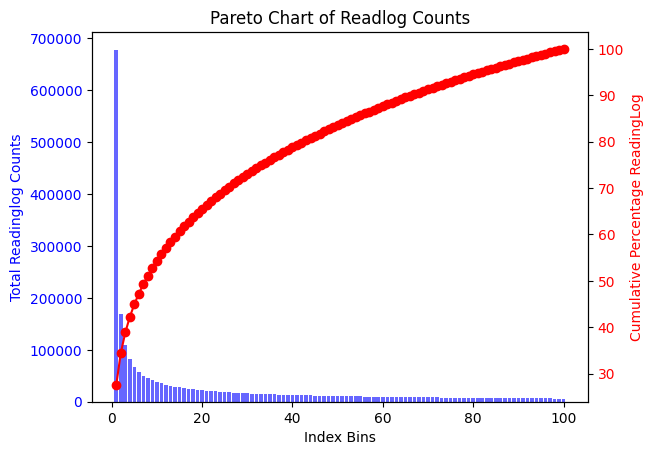

Our top 11 bins (2200 books, or 1.31% of all read and rated english works, account for 80% of all readinglog counts.


In [24]:
"""
Analysis: Pareto Chart of Ordered Books' Readinglog Counts and Cumulative Percentage of Total Counts
"""

# Define the bin size
bin_size = 200

# Create bins and group by these bins
data_df['bin'] = (data_df.index // bin_size) + 1
bin_totals = data_df.groupby('bin')['readinglog_count'].sum().reset_index()

# Calculate cumulative sum and cumulative percentage
bin_totals['cumulative_sum'] = bin_totals['readinglog_count'].cumsum()
bin_totals['cumulative_percentage'] = bin_totals['cumulative_sum'] / bin_totals['readinglog_count'].sum() * 100

fig, ax1 = plt.subplots()

# Plot total read counts on the primary y-axis
ax1.bar(bin_totals['bin'], bin_totals['readinglog_count'], color='b', alpha=0.6)
ax1.set_xlabel('Index Bins')
ax1.set_ylabel('Total Readinglog Counts', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Plot cumulative percentage on the secondary y-axis
ax2 = ax1.twinx()
ax2.plot(bin_totals['bin'], bin_totals['cumulative_percentage'], color='r', marker='o', linestyle='-')
ax2.set_ylabel('Cumulative Percentage ReadingLog', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('Pareto Chart of Readlog Counts')
plt.show()

print(f"Our top 11 bins (2200 books, or {round((2200/167484)*100,2)}% of all read and rated english works, account for 80% of all readinglog counts.")

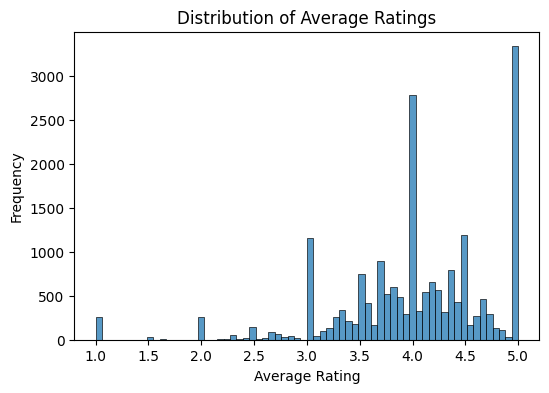

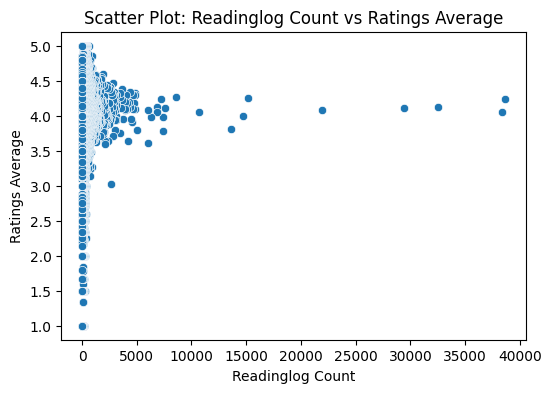

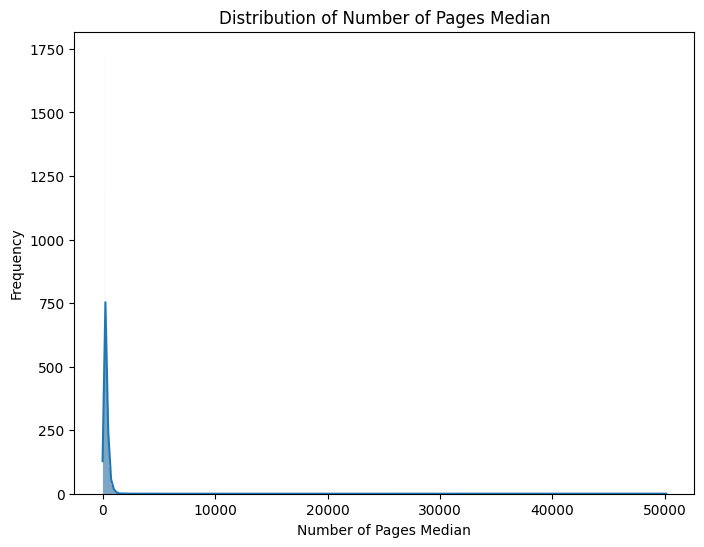

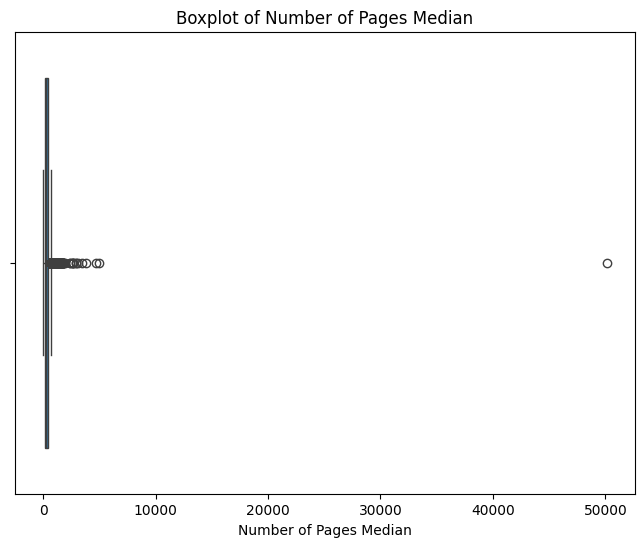

In [27]:
# Histogram with KDE
plt.figure(figsize=(6, 4))
sns.histplot(data_df['ratings_average'])
plt.title('Distribution of Average Ratings')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.show()

# Scatter plot of readinglog_count vs. ratings_average
plt.figure(figsize=(6, 4))
sns.scatterplot(x='readinglog_count', y='ratings_average', data=data_df)
plt.title('Scatter Plot: Readinglog Count vs Ratings Average')
plt.xlabel('Readinglog Count')
plt.ylabel('Ratings Average')
plt.show()

# Histogram with KDE
plt.figure(figsize=(8, 6))
sns.histplot(data_df['number_of_pages_median'], kde=True)
plt.title('Distribution of Number of Pages Median')
plt.xlabel('Number of Pages Median')
plt.ylabel('Frequency')
plt.show()

# Boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=data_df, x='number_of_pages_median')
plt.title('Boxplot of Number of Pages Median')
plt.xlabel('Number of Pages Median')
plt.show()

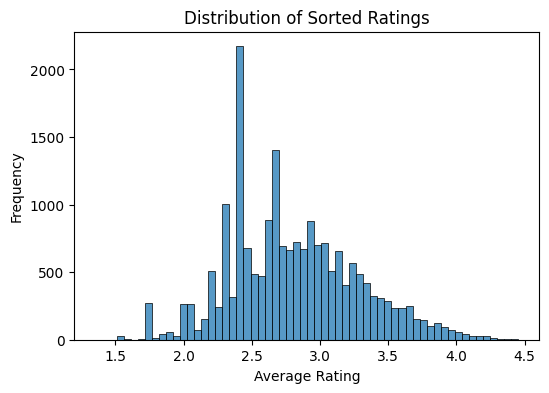

In [28]:
#plt.hist(data_df['ratings_sortable'])
# Histogram with KDE
plt.figure(figsize=(6, 4))
sns.histplot(data_df['ratings_sortable'])
plt.title('Distribution of Sorted Ratings')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.show()


Text(0.5, 1.0, 'Open Library Unread to Read Pipeline')

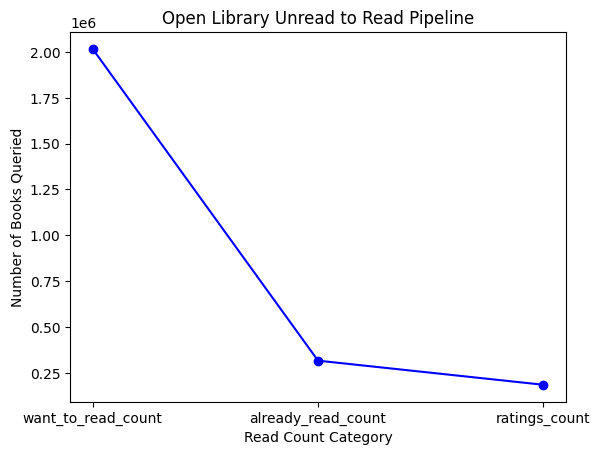

In [29]:
labels = ['want_to_read_count', 'already_read_count', 'ratings_count']
sums = []
for label in labels:
    sums.append(data_df[label].sum())

# Plot engagement pipeline
plt.plot(labels, sums, marker='o', linestyle='-', color='b', label='Read Count')
plt.xlabel('Read Count Category')
plt.ylabel('Number of Books Queried')
plt.title('Open Library Unread to Read Pipeline')